In [1]:
import numpy as np
import matplotlib.pyplot as plt

# function approximation

Consider the function

$$
f(x) = \dfrac{\sin(x^x)}{2^{(x^x-\pi/2)/\pi}}
$$

In [88]:
# plot f(x) over the interval [0,3]
m=2000
x=np.linspace(0,3,m)
y=np.sin(x**x)/2**(x**x-(np.pi/2)/np.pi)
x.shape,y.shape

((2000,), (2000,))

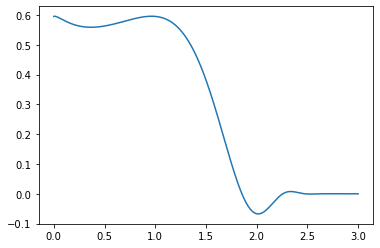

In [89]:
plt.plot(x,y)

The goal is to train a neural network that approximates the function $f(x)$ over the interval [0,3].

In [90]:
# neural network stuff
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        
# linear activation function: outputs = inputs
class linear:

    def forward(self, inputs):
        # flatten the output
        self.inputs = inputs
        self.output = inputs.flatten()

    def backward(self, dinputs):
        # derivative of x is 1 
        self.dinputs = dinputs.copy().reshape(-1,1) # reshape the result as a column vector
        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs)
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

# mean squeared error        
class loss_mse():

    def forward(self, y_pred, y_true):

    # calculate loss
        sample_losses = (y_true - y_pred)**2
        # return losses
        return sample_losses

    def backward(self, y_pred, y_true):

        # number of data points
        samples = len(y_pred)

        # gradient 
        self.dinputs = -2 * (y_true - y_pred) 

        # normalize gradient
        self.dinputs = self.dinputs / samples
        
# categorical cross entropy
class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
        
        
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

In [91]:
# build a neural network
# neural Net initialization

# layer 1
layer1 = layer(n_inputs = 1, n_neurons = 64)
activation1 = ReLU()

# layer 2
layer2 = layer(n_inputs = 64, n_neurons = 64)
activation2 = ReLU() 

# layer 3 
layer3 = layer(n_inputs = 64, n_neurons = 1)
activation3  = linear()

# loss function = mean squared error
loss_function = loss_mse()

# optimizer
optimizer = optimizer_GD(learning_rate = 0.4)

In [92]:
x=x.reshape(m,-1)
y
x.shape,y.shape

((2000, 1), (2000,))

In [93]:
# train a neural network
#gradient descent interation
n_epochs = 5000
error = np.zeros(n_epochs)
y_pred = np.zeros(y.shape)
for epoch in range(n_epochs):
    #forward pass
    layer1.forward(x)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    #loss
    losses=loss_function.forward(activation3.output,y)
    
    # backwards pass
    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    layer3.backward(activation3.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)
    
    # print the mean squared error (every 100 epochs)
    if epoch %100 ==0:
        print('---------')
        print('epoch: '+ str(epoch))
        print('loss '+ str(np.mean(losses)))
        print('-------------')

---------
epoch: 0
loss 0.14895719520995246
-------------
---------
epoch: 100
loss 0.009579937967264503
-------------
---------
epoch: 200
loss 0.005724678228140402
-------------
---------
epoch: 300
loss 0.0034076948805237947
-------------
---------
epoch: 400
loss 0.0016270067911126273
-------------
---------
epoch: 500
loss 0.0006880298629572712
-------------
---------
epoch: 600
loss 0.000328522117911286
-------------
---------
epoch: 700
loss 0.00020827336551131588
-------------
---------
epoch: 800
loss 0.00016105575754185998
-------------
---------
epoch: 900
loss 0.00013963122681139928
-------------
---------
epoch: 1000
loss 0.00012825289229384927
-------------
---------
epoch: 1100
loss 0.00012123505417765157
-------------
---------
epoch: 1200
loss 0.00011681019081234863
-------------
---------
epoch: 1300
loss 0.0001506704826805908
-------------
---------
epoch: 1400
loss 0.0005016019506032528
-------------
---------
epoch: 1500
loss 0.00012945620484546355
-------------
--

In [94]:
# plot the approximation
ypred=activation3.output
ypred.shape

(2000,)

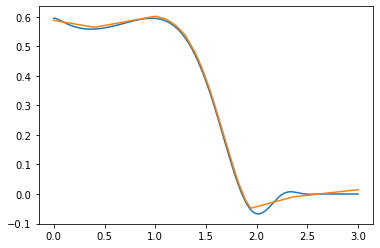

In [96]:
plt.plot(x,y)
plt.plot(x,ypred)
